In [1]:
from gensn.distributions import TrainableDistributionAdapter, Joint
from gensn.variational import ELBOMarginal, VariationalDequantizedDistribution
from gensn.parameters import TransformedParameter, PositiveDiagonal, Covariance
from gensn.flow import FlowDistribution
import gensn.transforms.invertible as T
from gensn.transforms.surjective import StepQuantizer
import gensn.distributions as G
import torch.distributions as D

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.optim import Adam

Prepare quantized dataset

In [3]:
z_distr = G.IndependentNormal(torch.Tensor([5]), torch.Tensor([1.0]))

Get samples and quantize

In [4]:
z_samples = z_distr.sample((1000,))

In [5]:
quantizer = StepQuantizer()

In [6]:
x_samples = quantizer(z_samples)

We are going to use flow dequantizer along with simple trainable gaussian as the prior for dequantization

In [77]:
# prepare the flow-based dequantizer. It's important that the dequantizer agrees with the quantizer about the support.
# for dequantizer flow, it's more intuitive to build the flow from base_distribution -> sample and then invert

layers = [
    T.IndependentAffine(),
    T.ELU(),
    T.IndependentAffine(),
    T.ELU(),
    T.IndependentAffine(),
    T.Sigmoid(), # this limits the output to (0, 1)
    T.ConditionalShift(nn.Identity()) # this ensures output falls within (x, x+1)
]
base_to_sample = T.SequentialTransform(*layers)


# Initialize the affine layers
init_std = 0.01
def init_module(module):
    if isinstance(module, T.IndependentAffine):
        module.weight.data.normal_(mean=1.0, std=init_std)
        module.bias.data.zero_()

base_to_sample.apply(init_module)

SequentialTransform(
  (transforms): ModuleList(
    (0): IndependentAffine()
    (1): ELU()
    (2): IndependentAffine()
    (3): ELU()
    (4): IndependentAffine()
    (5): Sigmoid()
    (6): ConditionalShift(
      (conditional_shift): Identity()
    )
  )
)

In [85]:
with torch.no_grad():
    x = torch.linspace(-5, 5, 1000)[:, None]
    z, _ = base_to_sample.forward(x, cond=torch.Tensor([[5.0]]))
    x_rec, _ = base_to_sample.inverse(z, cond=torch.Tensor([[5.0]]))


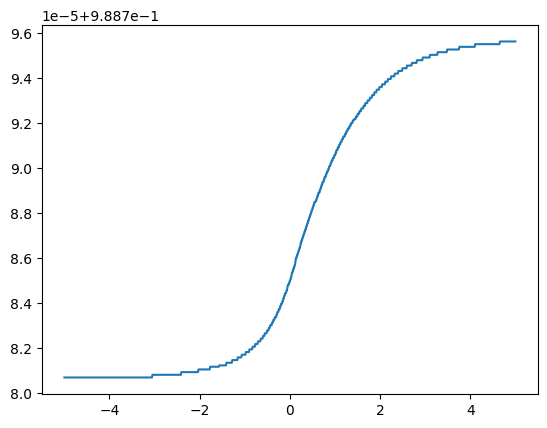

In [86]:
plt.plot(x.flatten(), x_rec.flatten())

In [43]:
# we create the base distribution to be conditionally dependent on discretized value
class CondScale(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(1, 1)
    def forward(self, x):
        return self.lin(x)**2

flow_base_distr = G.IndependentNormal(nn.Linear(1,1), CondScale())

def init(module):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(std=init_std)
        module.bias.data.zero_()

flow_base_distr.apply(init)
#flow_base_distr = G.IndependentNormal(nn.Parameter(torch.Tensor([0.0])), TransformedParameter(torch.Tensor([1.0]), lambda x: x**2))


IndependentNormal(
  (trainable_distribution): TrainableDistributionAdapter(
    (loc): Linear(in_features=1, out_features=1, bias=True)
    (scale): CondScale(
      (lin): Linear(in_features=1, out_features=1, bias=True)
    )
  )
)

In [44]:
# now build the flow distribution. Remember to inverse the transform
flow_dequant = FlowDistribution(flow_base_distr, T.InverseTransform(base_to_sample))

In [45]:
# prepare the prior distribution over dequantized value. Here we'll use simple trainable Gaussian
dequant_distr = G.IndependentNormal(nn.Parameter(torch.Tensor([0.0])), TransformedParameter(torch.Tensor([1.0]), lambda x: x**2))

In [46]:
model_distr = VariationalDequantizedDistribution(dequant_distr, flow_dequant, quantizer)

In [47]:
optim = Adam(model_distr.parameters(), lr=0.1)

In [49]:
for _ in range(1000):
    optim.zero_grad()
    # target_samples = target_distr.sample((1000,))
    # target_logL = target_distr.log_prob(target_samples).mean()
    nll = -model_distr(x_samples).mean()
    print(f'Model LL: {-nll}')
    nll.backward()
    optim.step()

Model LL: 94.94684600830078
Model LL: 94.94818878173828
Model LL: 94.94332885742188
Model LL: 94.95148468017578
Model LL: 94.94393920898438
Model LL: 94.94644165039062
Model LL: 94.94908142089844
Model LL: 94.95133972167969
Model LL: 94.94662475585938
Model LL: 94.9592514038086
Model LL: 94.9560775756836
Model LL: 94.93982696533203
Model LL: 94.93216705322266
Model LL: 94.96080017089844
Model LL: 94.94707489013672
Model LL: 94.9571533203125
Model LL: 94.93748474121094
Model LL: 94.9591293334961
Model LL: 94.97571563720703
Model LL: 94.96464538574219
Model LL: 94.9612808227539
Model LL: 94.95401000976562
Model LL: 94.9608154296875
Model LL: 94.96295166015625
Model LL: 94.96286010742188
Model LL: 94.94180297851562
Model LL: 94.97042846679688
Model LL: 94.95696258544922
Model LL: 94.9573974609375
Model LL: 94.94644165039062
Model LL: 94.93281555175781
Model LL: 94.95777893066406
Model LL: 94.95759582519531
Model LL: 94.95259857177734
Model LL: 94.93951416015625
Model LL: 94.94959259033203

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,  22.,  97., 260., 361.,
        200.,  57.,   3.]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,
         8.,  9.]),
 <BarContainer object of 14 artists>)

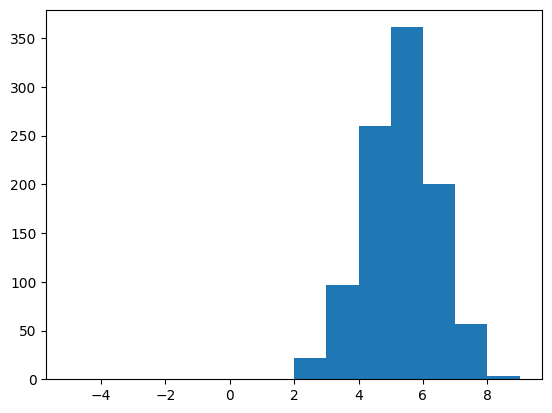

In [50]:
model_x_samples = model_distr.sample((1000,))
plt.hist(model_x_samples.flatten(), bins=np.arange(-5, 10))

(array([  0.,   0.,   0.,   0.,   0.,   0.,   1.,  17.,  96., 283., 349.,
        198.,  52.,   4.]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,
         8.,  9.]),
 <BarContainer object of 14 artists>)

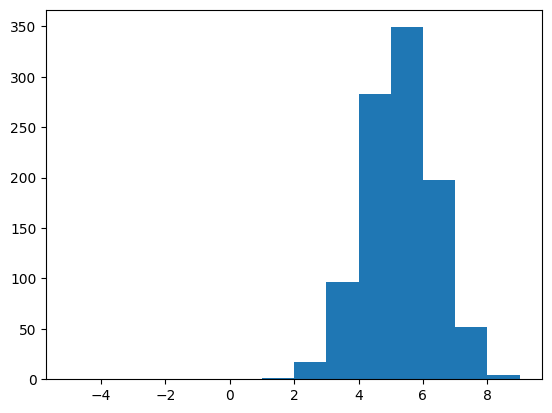

In [51]:
model_x_samples = model_distr.dequantized_distribution.sample((1000,))
plt.hist(model_x_samples.flatten(), bins=np.arange(-5, 10))

In [52]:
x_samples[:5]

tensor([[5.],
        [4.],
        [5.],
        [4.],
        [3.]])

In [53]:
z_samples = model_distr.dequantizer.sample((1,), cond=x_samples[0:5])

In [54]:
z_samples

tensor([[[5.5751],
         [5.0000],
         [5.5751],
         [4.5751],
         [4.0000]]], grad_fn=<AddBackward0>)

In [55]:
z = torch.linspace(0, 10, 1000)[:, None]

In [56]:
with torch.no_grad():
    z_samples = model_distr.dequantizer.sample((1000,), cond=x_samples[0])

In [57]:
x_samples[0]

tensor([5.])

(array([558.,   5.,   0.,   2.,   7.,   4.,   1.,   2.,   2., 419.]),
 array([5.57512951, 5.61761665, 5.6601038 , 5.70259047, 5.74507761,
        5.78756475, 5.8300519 , 5.87253904, 5.91502571, 5.95751286,
        6.        ]),
 <BarContainer object of 10 artists>)

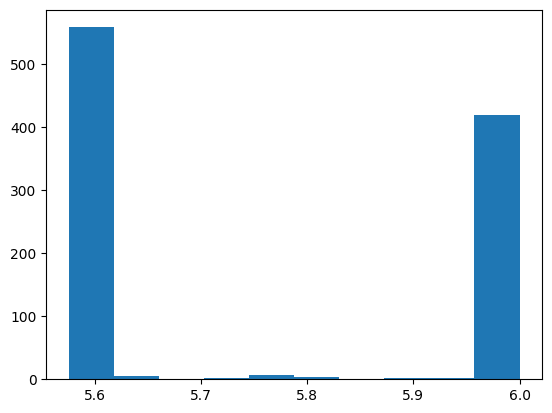

In [58]:
plt.hist(z_samples.flatten())

In [59]:
with torch.no_grad():
    v = model_distr.dequantizer.log_prob(z, cond=x_samples[0])

In [ ]:
model_distr.dequantized_distribution

In [69]:
with torch.no_grad():
    z = torch.linspace(5,6,1000)[:, None]
    x, logdet = model_distr.dequantizer.transform(z, cond=x_samples[0])

In [75]:
with torch.no_grad():
    z_rec, _ = model_distr.dequantizer.transform.inverse(x, cond=x_samples[0])

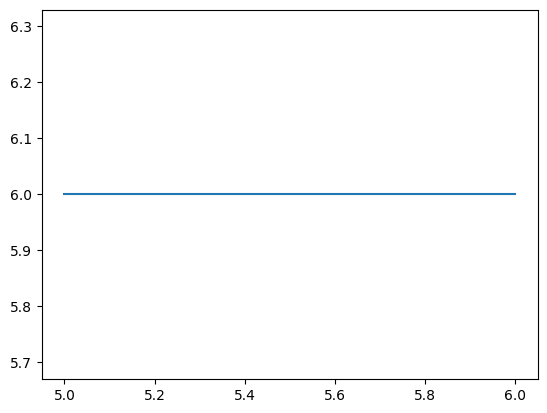

In [76]:
plt.plot(z.flatten(), z_rec.flatten())

In [72]:
np.exp(logdet.mean())

tensor(0.0015)

In [74]:
1 / ((z.max() - z.min()) / (x.max() - x.min()))

tensor(0.0016)

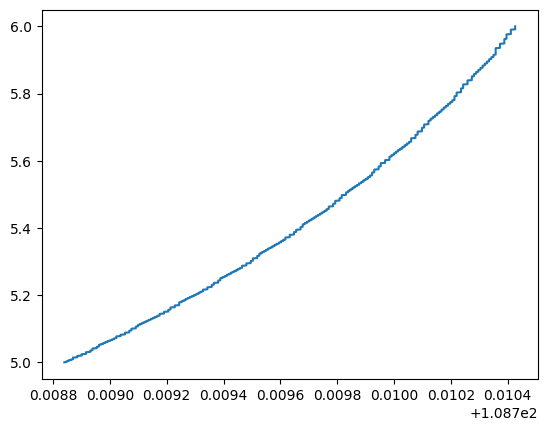

In [68]:
plt.plot(x.flatten(), z.flatten())

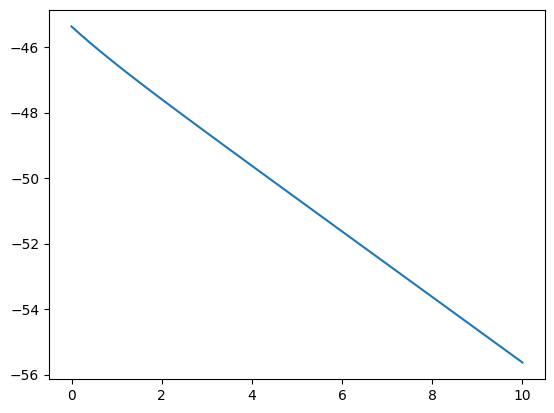

In [61]:
plt.plot(z, v)

In [27]:
z_prob = model_distr.dequantizer.log_prob(z, cond=x_samples[0])

In [23]:
model_distr.dequantizer.log_prob(z_samples, cond=x_samples[:5])

tensor([-82499.9297, -82483.9844, -82499.9297, -82483.9844, -82379.1641],
       grad_fn=<AddBackward0>)

In [24]:
model_distr.state_dict()

OrderedDict([('dequantized_distribution.trainable_distribution.loc',
              tensor([4.8334])),
             ('dequantized_distribution.trainable_distribution.scale.parameter',
              tensor([1.0984])),
             ('dequantizer.base_distribution.trainable_distribution.loc',
              tensor([-1.1050])),
             ('dequantizer.base_distribution.trainable_distribution.scale.lin.weight',
              tensor([[33.6092]])),
             ('dequantizer.base_distribution.trainable_distribution.scale.lin.bias',
              tensor([33.7380])),
             ('dequantizer.transform.transform.transforms.0.weight',
              tensor([1.0863])),
             ('dequantizer.transform.transform.transforms.0.bias',
              tensor([1.9832])),
             ('dequantizer.transform.transform.transforms.2.weight',
              tensor([1.8638])),
             ('dequantizer.transform.transform.transforms.2.bias',
              tensor([-100.4926])),
             ('dequantizer.